<a href="https://colab.research.google.com/github/faizankshaikh/HomMul/blob/main/experiments/trial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiments with Self-Playing Deep Reinforcement Learning


In [1]:
#@title Required installation
# !pip install -q black gymnasium pettingzoo==1.22.3 tianshou
# !git clone https://github.com/faizankshaikh/HomMul.git

In [2]:
#@title Change working path
%cd HomMul/

/content/HomMul


In [3]:
#@title Import libraries and modules
%load_ext tensorboard

import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from hommul.envs.hommul_v0 import HomMul

from torch.optim import Adam

from tianshou.data import Batch
from tianshou.utils.net.common import Net
from tianshou.utils import TensorboardLogger
from tianshou.trainer import offpolicy_trainer
from tianshou.data import Collector, VectorReplayBuffer
from tianshou.env import DummyVectorEnv, PettingZooEnv
from tianshou.policy import BasePolicy, DQNPolicy, MultiAgentPolicyManager

from pettingzoo.utils import parallel_to_aec

from torch.utils.tensorboard import SummaryWriter

In [4]:
#@title Setup Gymnasium environment
env = HomMul()
original_env = HomMul(render_mode="human")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
#@title Example of gameplay
episodes = 2

for episode in range(episodes):
    print(f"Episode #{episode+1}")
    print("=" * 10)
    obs = original_env.reset()
    print()

    while original_env.agents:
        acts = {
            "player1": np.random.choice([0, 1]),
            "player2": np.random.choice([0, 1])
        }
        print(f"--Action taken by player 1: {original_env.action_dict[acts['player1']]}")
        print(f"--Action taken by player 2: {original_env.action_dict[acts['player2']]}")
        print()

        obs, rews, terms, truncs, infos = original_env.step(acts)
        print()

Episode #1
--Days left: 2
--Current life of agent 1: 1
--Current life of agent 2: 2
--Probability of payoff for agent 1: 0.2
--Probability of payoff for agent 2: 0.2

--Action taken by player 1: play
--Action taken by player 2: play

--Days left: 1
--Current life of agent 1: 0
--Current life of agent 2: 0
--Probability of payoff for agent 1: 0.2
--Probability of payoff for agent 2: 0.2
--Previous action of agent 1: play
--Previous action of agent 2: play

Episode #2
--Days left: 2
--Current life of agent 1: 3
--Current life of agent 2: 2
--Probability of payoff for agent 1: 0.4
--Probability of payoff for agent 2: 0.4

--Action taken by player 1: wait
--Action taken by player 2: play

--Days left: 1
--Current life of agent 1: 2
--Current life of agent 2: 0
--Probability of payoff for agent 1: 0.2
--Probability of payoff for agent 2: 0.2
--Previous action of agent 1: wait
--Previous action of agent 2: play

--Action taken by player 1: play
--Action taken by player 2: play

--Days left: 

## Heuristics Benchmarking


death rate of player2: 0.315
ratio of death rate of player2 with respect to player1: 0.873


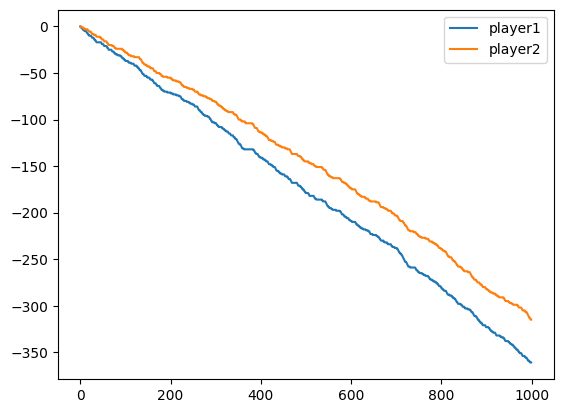

In [6]:
#@title Case - both always play
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": 1,
            "player2": 1
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

arr = np.array(episode_rews)
death_rates = np.sum(arr, axis=0) / np.sum(arr, axis=0)[0]
print(f"death rate of player2: {(np.sum(arr, axis=0) / arr.shape[0])[-1] * -1:.3f}")
print(f"ratio of death rate of player2 with respect to player1: {death_rates[-1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

death rate of player2: 0.436
ratio of death rate of player2 with respect to player1: 0.669


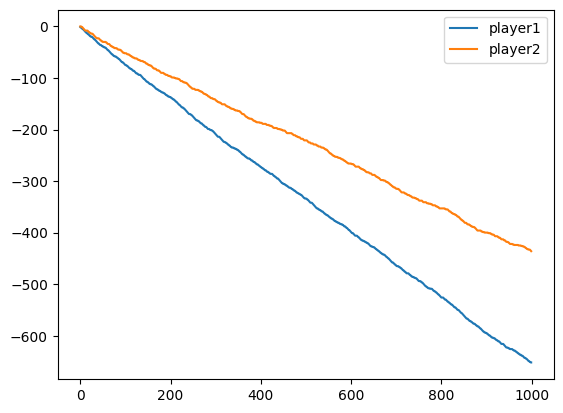

In [7]:
#@title Case - both always wait
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": 0,
            "player2": 0
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

arr = np.array(episode_rews)
death_rates = np.sum(arr, axis=0) / np.sum(arr, axis=0)[0]
print(f"death rate of player2: {(np.sum(arr, axis=0) / arr.shape[0])[-1] * -1:.3f}")
print(f"ratio of death rate of player2 with respect to player1: {death_rates[-1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

death rate of player2: 0.552
ratio of death rate of player2 with respect to player1: 0.857


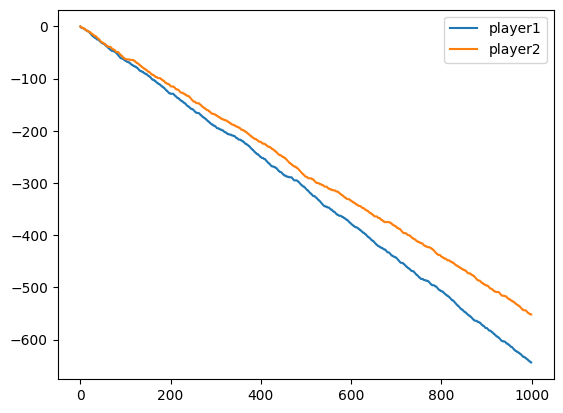

In [8]:
#@title Case - player1 waits, player2 plays
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": 0,
            "player2": 1
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

arr = np.array(episode_rews)
death_rates = np.sum(arr, axis=0) / np.sum(arr, axis=0)[0]
print(f"death rate of player2: {(np.sum(arr, axis=0) / arr.shape[0])[-1] * -1:.3f}")
print(f"ratio of death rate of player2 with respect to player1: {death_rates[-1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

death rate of player2: 0.437
ratio of death rate of player2 with respect to player1: 0.696


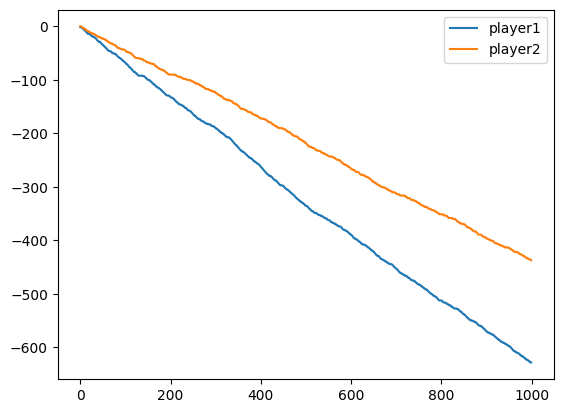

In [9]:
#@title Case - player1 plays, player2 waits
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": 1,
            "player2": 0
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

arr = np.array(episode_rews)
death_rates = np.sum(arr, axis=0) / np.sum(arr, axis=0)[0]
print(f"death rate of player2: {(np.sum(arr, axis=0) / arr.shape[0])[-1] * -1:.3f}")
print(f"ratio of death rate of player2 with respect to player1: {death_rates[-1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

death rate of player2: 0.378
ratio of death rate of player2 with respect to player1: 0.751


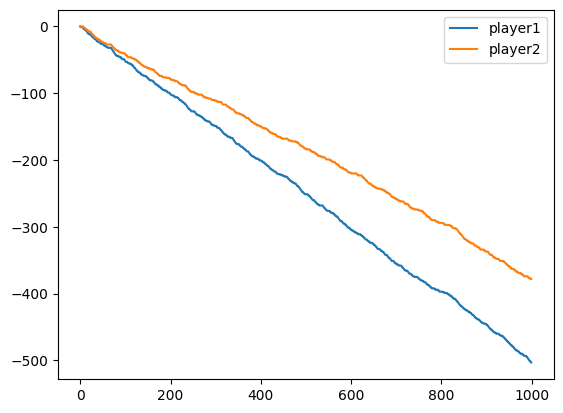

In [10]:
#@title Case - Always play vs random agent
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": 1,
            "player2": np.random.choice([0, 1])
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

arr = np.array(episode_rews)
death_rates = np.sum(arr, axis=0) / np.sum(arr, axis=0)[0]
print(f"death rate of player2: {(np.sum(arr, axis=0) / arr.shape[0])[-1] * -1:.3f}")
print(f"ratio of death rate of player2 with respect to player1: {death_rates[-1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

death rate of player2: 0.504
ratio of death rate of player2 with respect to player1: 0.816


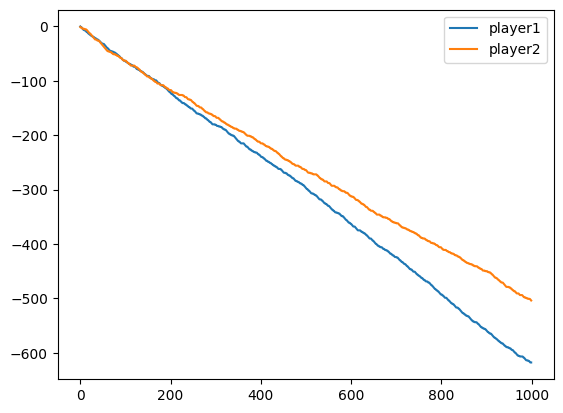

In [11]:
#@title Case - Always wait vs random agent
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": 0,
            "player2": np.random.choice([0, 1])
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

arr = np.array(episode_rews)
death_rates = np.sum(arr, axis=0) / np.sum(arr, axis=0)[0]
print(f"death rate of player2: {(np.sum(arr, axis=0) / arr.shape[0])[-1] * -1:.3f}")
print(f"ratio of death rate of player2 with respect to player1: {death_rates[-1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

death rate of player2: 0.196
ratio of death rate of player2 with respect to player1: 0.341


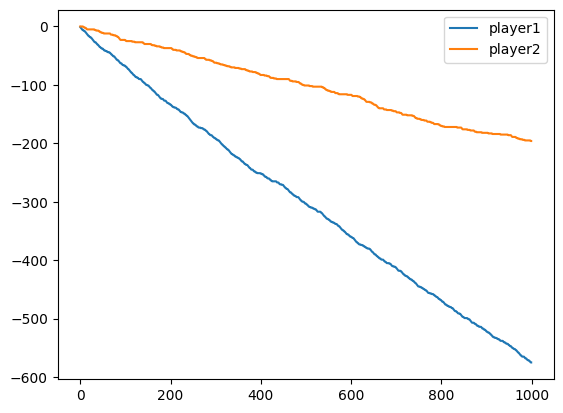

In [12]:
#@title Case - Always play vs hail mary
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": 1,
            "player2": 1 if obs["player2"]["observation"][0, 2] <= 1 else 0
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

arr = np.array(episode_rews)
death_rates = np.sum(arr, axis=0) / np.sum(arr, axis=0)[0]
print(f"death rate of player2: {(np.sum(arr, axis=0) / arr.shape[0])[-1] * -1:.3f}")
print(f"ratio of death rate of player2 with respect to player1: {death_rates[-1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

death rate of player2: 0.308
ratio of death rate of player2 with respect to player1: 0.501


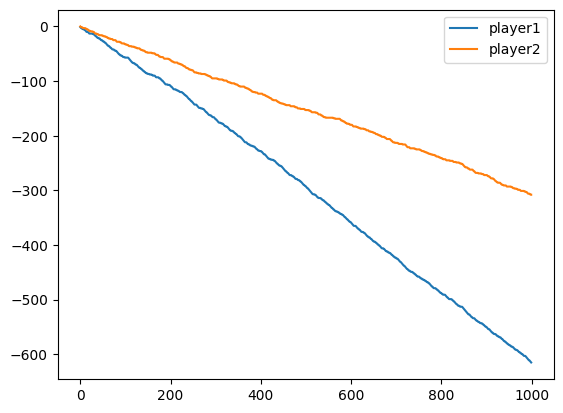

In [13]:
#@title Case - Always wait vs hail mary
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": 0,
            "player2": 1 if obs["player2"]["observation"][0, 2] <= 1 else 0
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

arr = np.array(episode_rews)
death_rates = np.sum(arr, axis=0) / np.sum(arr, axis=0)[0]
print(f"death rate of player2: {(np.sum(arr, axis=0) / arr.shape[0])[-1] * -1:.3f}")
print(f"ratio of death rate of player2 with respect to player1: {death_rates[-1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

In [14]:
#@title Load optimal policy

def optimal(obs):
    df = pd.read_csv("models/optimal_policy.csv")
    return df.loc[
        (df["days_left"] == obs["player1"]["observation"][0][0]) &
        (df["player1_life_points"] == obs["player1"]["observation"][0][1]) &
        (df["player2_life_points"] == obs["player1"]["observation"][0][2]) &
        (df["player1_prob_payoff"] == obs["player1"]["observation"][0][3])
    ]["action"].values[0] - 1

death rate of player2: 0.251
ratio of death rate of player2 with respect to player1: 0.472


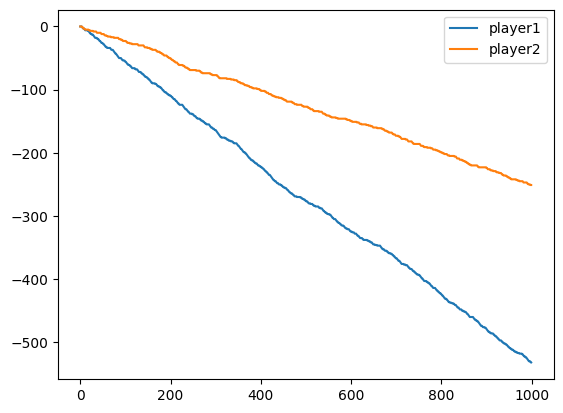

In [15]:
#@title Case - hail mary vs optimal
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": 1 if obs["player2"]["observation"][0, 2] <= 1 else 0,
            "player2": optimal(obs)
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

arr = np.array(episode_rews)
death_rates = np.sum(arr, axis=0) / np.sum(arr, axis=0)[0]
print(f"death rate of player2: {(np.sum(arr, axis=0) / arr.shape[0])[-1] * -1:.3f}")
print(f"ratio of death rate of player2 with respect to player1: {death_rates[-1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


death rate of player2: 0.379
ratio of death rate of player2 with respect to player1: 0.625


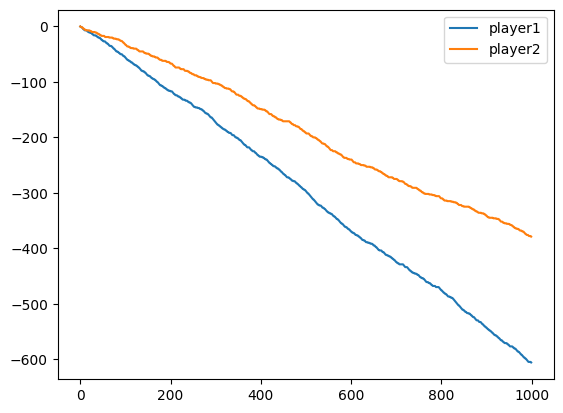

In [16]:
#@title Case - Always wait vs optimal
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": 0,
            "player2": optimal(obs)
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

arr = np.array(episode_rews)
death_rates = np.sum(arr, axis=0) / np.sum(arr, axis=0)[0]
print(f"death rate of player2: {(np.sum(arr, axis=0) / arr.shape[0])[-1] * -1:.3f}")
print(f"ratio of death rate of player2 with respect to player1: {death_rates[-1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


death rate of player2: 0.200
ratio of death rate of player2 with respect to player1: 0.418


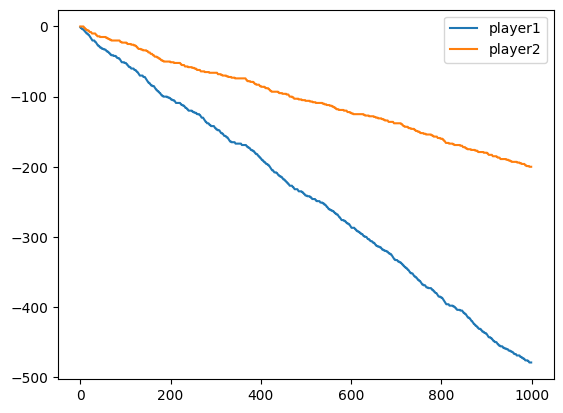

In [17]:
#@title Case - Always play vs optimal
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": 1,
            "player2": optimal(obs)
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

arr = np.array(episode_rews)
death_rates = np.sum(arr, axis=0) / np.sum(arr, axis=0)[0]
print(f"death rate of player2: {(np.sum(arr, axis=0) / arr.shape[0])[-1] * -1:.3f}")
print(f"ratio of death rate of player2 with respect to player1: {death_rates[-1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

## Deep RL training


In [18]:
#@title Define heuristic algos in Tianshou
## agent that always plays
class AlwaysPlay(BasePolicy):
    def __init__(self, **kwargs):
        self.nolearn = True
        super().__init__(**kwargs)
    
    def forward(self, batch, state = None):
        mask = batch.obs.mask
        logits = np.zeros(mask.shape)
        logits[:, 1] = 1
        logits[~mask] = -np.inf
        return Batch(act=logits.argmax(axis=-1))

    def learn(self, batch):
        return {}

## agent that always waits
class AlwaysWait(BasePolicy):
    def __init__(self, **kwargs):
        self.nolearn = True
        super().__init__(**kwargs)

    def forward(self, batch, state = None):
        mask = batch.obs.mask
        logits = np.zeros(mask.shape)
        logits[:, 0] = 1
        logits[~mask] = -np.inf
        return Batch(act=logits.argmax(axis=-1))

    def learn(self, batch):
        return {}

## agent that waits for low health to play
class HailMary(BasePolicy):
    def __init__(self, **kwargs):
        self.nolearn = True
        super().__init__(**kwargs)

    def forward(self, batch, state = None):
        mask = batch.obs.mask
        logits = np.zeros(mask.shape)
        obs = batch.obs.obs

        for i in range(mask.shape[0]):
            if obs[i, :, 1] <= 1:
                logits[i, 1] = 1
            else:
                logits[i, 0] = 1
        logits[~mask] = -np.inf
        return Batch(act=logits.argmax(axis=-1))

    def learn(self, batch):
        return {}

## optimal agent 
class OptimalPolicy(BasePolicy):
    def __init__(self, **kwargs):
        self.nolearn = True
        super().__init__(**kwargs)

    def forward(self, batch, state = None):
        mask = batch.obs.mask
        logits = np.zeros(mask.shape)
        obs = batch.obs.obs

        df = pd.read_csv("models/optimal_policy.csv")

        for i in range(mask.shape[0]):
            action = df.loc[
                (df["days_left"] == obs[i, :, 0][0]) &
                (df["player1_life_points"] == obs[i, :, 1][0]) &
                (df["player2_life_points"] == obs[i, :, 2][0]) &
                (df["player1_prob_payoff"] == obs[i, :, 3][0])
            ]["action"].values[0] - 1
            if action:
                logits[i, 1] = 1
            else:
                logits[i, 0] = 1
        logits[~mask] = -np.inf
        return Batch(act=logits.argmax(axis=-1))

    def learn(self, batch):
        return {}

## random agent
class RandomAgent(BasePolicy):
    def __init__(self, **kwargs):
        self.nolearn = True
        super().__init__(**kwargs)

    def forward(self, batch, state = None):
        mask = batch.obs.mask
        logits = np.zeros(mask.shape)
        logits[:, np.random.choice([0, 1])] = 1
        logits[~mask] = -np.inf
        return Batch(act=logits.argmax(axis=-1))

    def learn(self, batch):
        return {}

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [19]:
#@title Prerequisites for training
# Step 2: Wrap the environment for Tianshou interfacing
def _get_env():
    env = HomMul()
    vec_env = parallel_to_aec(env)
    return PettingZooEnv(vec_env)

# seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

env = HomMul()
agents =  env.agents[:]

# Step 3: Define policies for each agent
## learning agent
def _get_agent(pretrained=False):
    vec_env = _get_env()
    net = Net(
        state_shape=vec_env.observation_space.shape,
        action_shape=vec_env.action_space.n,
        hidden_sizes=[128, 128],
        device="cuda",
    ).to("cuda")
    optim = Adam(net.parameters(), lr=1e-4)
    model = DQNPolicy(
        model=net,
        optim=optim,
        discount_factor=0.9,
        estimation_step=3,
        target_update_freq=50,
    )

    if pretrained:
        model_save_path = os.path.join("models", "vs_hail_mary.pth")
        model.load_state_dict(torch.load(model_save_path))
    return model

agent_learn1 = _get_agent(pretrained=True)
agent_learn2 = _get_agent(pretrained=True)

policy = MultiAgentPolicyManager([agent_learn1, agent_learn2],  _get_env())

train_envs = DummyVectorEnv([_get_env for _ in range(5)])
test_envs = DummyVectorEnv([_get_env for _ in range(2)])
train_envs.seed(seed)
test_envs.seed(seed)

# Step 4: Collector setup
train_collector = Collector(
    policy,
    train_envs,
    VectorReplayBuffer(20_000, len(train_envs)),
    exploration_noise=True,
)
test_collector = Collector(policy, test_envs, exploration_noise=True)

train_collector.collect(n_step=50)

def save_best_fn(policy):
    model_save_path1 = os.path.join("log", "hommul", "dqn", "policy1.pth")
    model_save_path2 = os.path.join("log", "hommul", "dqn", "policy2.pth")
    os.makedirs(os.path.join("log", "hommul", "dqn"), exist_ok=True)
    if not hasattr(policy.policies[agents[0]], 'nolearn'):
        torch.save(policy.policies[agents[0]].state_dict(), model_save_path1)
    if not hasattr(policy.policies[agents[1]], 'nolearn'):
        torch.save(policy.policies[agents[1]].state_dict(), model_save_path2)

def stop_fn(mean_rewards):
    return mean_rewards >= 10

def train_fn(epoch, env_step):
    # freeze training for player1
    if not hasattr(policy.policies[agents[0]], 'nolearn'):
        policy.policies[agents[0]].set_eps(0.05)

    if not hasattr(policy.policies[agents[1]], 'nolearn'):
        policy.policies[agents[1]].set_eps(0.1)

def test_fn(epoch, env_step):
    if not hasattr(policy.policies[agents[0]], 'nolearn'):
        policy.policies[agents[0]].set_eps(0.05)

    if not hasattr(policy.policies[agents[1]], 'nolearn'):
        policy.policies[agents[1]].set_eps(0.05)

def reward_metric(rews):
    return rews[:, 1]

In [20]:
#@title Clear logs and setup TensorBoard
!rm -rf /content/HomMul/log

log_path = os.path.join("log", "hommul", "dqn")
writer = SummaryWriter(log_path)
logger = TensorboardLogger(writer)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
#@title Training
# Step 5: Run trainer
result = offpolicy_trainer(
    policy=policy,
    train_collector=train_collector,
    test_collector=test_collector,
    max_epoch=100,
    step_per_epoch=1000,
    step_per_collect=50,
    episode_per_test=100,
    batch_size=64,
    train_fn=train_fn,
    test_fn=test_fn,
    stop_fn=stop_fn,
    save_best_fn=save_best_fn,
    update_per_step=0.1,
    test_in_train=False,
    reward_metric=reward_metric,
    logger=logger
)
result

Epoch #1: 1001it [00:03, 331.75it/s, env_step=1000, len=3, n/ep=15, n/st=50, player1/loss=0.198, player2/loss=0.181, rew=-0.53]                          


Epoch #1: test_reward: -0.430000 ± 0.495076, best_reward: -0.230000 ± 0.420833 in #0


Epoch #2: 1001it [00:01, 719.45it/s, env_step=2000, len=2, n/ep=20, n/st=50, player1/loss=0.146, player2/loss=0.149, rew=-0.30]                          


Epoch #2: test_reward: -0.230000 ± 0.420833, best_reward: -0.230000 ± 0.420833 in #0


Epoch #3: 1001it [00:01, 816.01it/s, env_step=3000, len=3, n/ep=16, n/st=50, player1/loss=0.119, player2/loss=0.176, rew=-0.31]                          


Epoch #3: test_reward: -0.250000 ± 0.433013, best_reward: -0.230000 ± 0.420833 in #0


Epoch #4: 1001it [00:01, 850.21it/s, env_step=4000, len=2, n/ep=18, n/st=50, player1/loss=0.124, player2/loss=0.211, rew=-0.39]                          


Epoch #4: test_reward: -0.220000 ± 0.414246, best_reward: -0.220000 ± 0.414246 in #4


Epoch #5: 1001it [00:01, 828.45it/s, env_step=5000, len=2, n/ep=18, n/st=50, player1/loss=0.134, player2/loss=0.256, rew=-0.33]                          


Epoch #5: test_reward: -0.330000 ± 0.470213, best_reward: -0.220000 ± 0.414246 in #4


Epoch #6: 1001it [00:01, 818.43it/s, env_step=6000, len=3, n/ep=16, n/st=50, player1/loss=0.138, player2/loss=0.270, rew=-0.19]                          


Epoch #6: test_reward: -0.310000 ± 0.462493, best_reward: -0.220000 ± 0.414246 in #4


Epoch #7: 1001it [00:01, 797.65it/s, env_step=7000, len=2, n/ep=18, n/st=50, player1/loss=0.154, player2/loss=0.324, rew=-0.11]                          


Epoch #7: test_reward: -0.270000 ± 0.443959, best_reward: -0.220000 ± 0.414246 in #4


Epoch #8: 1001it [00:01, 810.04it/s, env_step=8000, len=2, n/ep=19, n/st=50, player1/loss=0.176, player2/loss=0.342, rew=-0.26]                          


Epoch #8: test_reward: -0.320000 ± 0.466476, best_reward: -0.220000 ± 0.414246 in #4


Epoch #9: 1001it [00:01, 609.09it/s, env_step=9000, len=2, n/ep=17, n/st=50, player1/loss=0.177, player2/loss=0.357, rew=-0.29]                          


Epoch #9: test_reward: -0.220000 ± 0.414246, best_reward: -0.220000 ± 0.414246 in #4


Epoch #10: 1001it [00:01, 690.77it/s, env_step=10000, len=2, n/ep=16, n/st=50, player1/loss=0.185, player2/loss=0.374, rew=-0.25]                          


Epoch #10: test_reward: -0.300000 ± 0.458258, best_reward: -0.220000 ± 0.414246 in #4


Epoch #11: 1001it [00:01, 815.50it/s, env_step=11000, len=2, n/ep=19, n/st=50, player1/loss=0.212, player2/loss=0.345, rew=-0.21]                          


Epoch #11: test_reward: -0.200000 ± 0.400000, best_reward: -0.200000 ± 0.400000 in #11


Epoch #12: 1001it [00:01, 795.72it/s, env_step=12000, len=2, n/ep=19, n/st=50, player1/loss=0.216, player2/loss=0.378, rew=-0.26]                          


Epoch #12: test_reward: -0.240000 ± 0.427083, best_reward: -0.200000 ± 0.400000 in #11


Epoch #13: 1001it [00:01, 792.19it/s, env_step=13000, len=2, n/ep=19, n/st=50, player1/loss=0.237, player2/loss=0.389, rew=-0.16]                          


Epoch #13: test_reward: -0.120000 ± 0.324962, best_reward: -0.120000 ± 0.324962 in #13


Epoch #14: 1001it [00:01, 795.39it/s, env_step=14000, len=2, n/ep=17, n/st=50, player1/loss=0.234, player2/loss=0.430, rew=-0.35]                          


Epoch #14: test_reward: -0.360000 ± 0.480000, best_reward: -0.120000 ± 0.324962 in #13


Epoch #15: 1001it [00:01, 818.37it/s, env_step=15000, len=2, n/ep=18, n/st=50, player1/loss=0.221, player2/loss=0.403, rew=-0.28]                          


Epoch #15: test_reward: -0.270000 ± 0.443959, best_reward: -0.120000 ± 0.324962 in #13


Epoch #16: 1001it [00:01, 795.00it/s, env_step=16000, len=2, n/ep=22, n/st=50, player1/loss=0.223, player2/loss=0.391, rew=-0.14]                          


Epoch #16: test_reward: -0.250000 ± 0.433013, best_reward: -0.120000 ± 0.324962 in #13


Epoch #17: 1001it [00:01, 625.89it/s, env_step=17000, len=2, n/ep=19, n/st=50, player1/loss=0.241, player2/loss=0.444, rew=-0.11]                          


Epoch #17: test_reward: -0.190000 ± 0.392301, best_reward: -0.120000 ± 0.324962 in #13


Epoch #18: 1001it [00:01, 679.34it/s, env_step=18000, len=2, n/ep=18, n/st=50, player1/loss=0.244, player2/loss=0.423, rew=-0.28]                          


Epoch #18: test_reward: -0.240000 ± 0.427083, best_reward: -0.120000 ± 0.324962 in #13


Epoch #19: 1001it [00:01, 764.96it/s, env_step=19000, len=2, n/ep=19, n/st=50, player1/loss=0.237, player2/loss=0.449, rew=-0.37]                          


Epoch #19: test_reward: -0.280000 ± 0.448999, best_reward: -0.120000 ± 0.324962 in #13


Epoch #20: 1001it [00:01, 792.76it/s, env_step=20000, len=2, n/ep=19, n/st=50, player1/loss=0.244, player2/loss=0.453, rew=-0.26]                          


Epoch #20: test_reward: -0.310000 ± 0.462493, best_reward: -0.120000 ± 0.324962 in #13


Epoch #21: 1001it [00:01, 822.62it/s, env_step=21000, len=2, n/ep=20, n/st=50, player1/loss=0.272, player2/loss=0.444, rew=-0.25]                          


Epoch #21: test_reward: -0.220000 ± 0.414246, best_reward: -0.120000 ± 0.324962 in #13


Epoch #22: 1001it [00:01, 817.87it/s, env_step=22000, len=3, n/ep=15, n/st=50, player1/loss=0.257, player2/loss=0.438, rew=-0.13]                          


Epoch #22: test_reward: -0.270000 ± 0.443959, best_reward: -0.120000 ± 0.324962 in #13


Epoch #23: 1001it [00:01, 813.00it/s, env_step=23000, len=3, n/ep=16, n/st=50, player1/loss=0.287, player2/loss=0.451, rew=-0.50]                          


Epoch #23: test_reward: -0.350000 ± 0.476970, best_reward: -0.120000 ± 0.324962 in #13


Epoch #24: 1001it [00:01, 822.83it/s, env_step=24000, len=3, n/ep=17, n/st=50, player1/loss=0.308, player2/loss=0.480, rew=-0.18]                          


Epoch #24: test_reward: -0.240000 ± 0.427083, best_reward: -0.120000 ± 0.324962 in #13


Epoch #25: 1001it [00:01, 651.02it/s, env_step=25000, len=2, n/ep=17, n/st=50, player1/loss=0.296, player2/loss=0.449, rew=-0.24]                          


Epoch #25: test_reward: -0.360000 ± 0.480000, best_reward: -0.120000 ± 0.324962 in #13


Epoch #26: 1001it [00:02, 423.38it/s, env_step=26000, len=2, n/ep=16, n/st=50, player1/loss=0.294, player2/loss=0.480, rew=-0.38]                          


Epoch #26: test_reward: -0.270000 ± 0.443959, best_reward: -0.120000 ± 0.324962 in #13


Epoch #27: 1001it [00:01, 633.18it/s, env_step=27000, len=3, n/ep=15, n/st=50, player1/loss=0.316, player2/loss=0.491, rew=-0.27]                          


Epoch #27: test_reward: -0.220000 ± 0.414246, best_reward: -0.120000 ± 0.324962 in #13


Epoch #28: 1001it [00:01, 796.74it/s, env_step=28000, len=3, n/ep=16, n/st=50, player1/loss=0.336, player2/loss=0.484, rew=-0.25]                          


Epoch #28: test_reward: -0.340000 ± 0.473709, best_reward: -0.120000 ± 0.324962 in #13


Epoch #29: 1001it [00:01, 807.11it/s, env_step=29000, len=2, n/ep=17, n/st=50, player1/loss=0.329, player2/loss=0.509, rew=-0.29]                          


Epoch #29: test_reward: -0.320000 ± 0.466476, best_reward: -0.120000 ± 0.324962 in #13


Epoch #30: 1001it [00:01, 814.65it/s, env_step=30000, len=2, n/ep=18, n/st=50, player1/loss=0.344, player2/loss=0.560, rew=-0.44]                          


Epoch #30: test_reward: -0.340000 ± 0.473709, best_reward: -0.120000 ± 0.324962 in #13


Epoch #31: 1001it [00:01, 801.83it/s, env_step=31000, len=2, n/ep=20, n/st=50, player1/loss=0.334, player2/loss=0.531, rew=-0.35]                          


Epoch #31: test_reward: -0.260000 ± 0.438634, best_reward: -0.120000 ± 0.324962 in #13


Epoch #32: 1001it [00:01, 773.58it/s, env_step=32000, len=2, n/ep=19, n/st=50, player1/loss=0.331, player2/loss=0.582, rew=-0.32]                          


Epoch #32: test_reward: -0.320000 ± 0.466476, best_reward: -0.120000 ± 0.324962 in #13


Epoch #33: 1001it [00:01, 622.88it/s, env_step=33000, len=2, n/ep=18, n/st=50, player1/loss=0.346, player2/loss=0.587, rew=-0.33]                          


Epoch #33: test_reward: -0.320000 ± 0.466476, best_reward: -0.120000 ± 0.324962 in #13


Epoch #34: 1001it [00:01, 772.90it/s, env_step=34000, len=2, n/ep=18, n/st=50, player1/loss=0.338, player2/loss=0.572, rew=-0.28]                          


Epoch #34: test_reward: -0.250000 ± 0.433013, best_reward: -0.120000 ± 0.324962 in #13


Epoch #35: 1001it [00:01, 769.70it/s, env_step=35000, len=2, n/ep=20, n/st=50, player1/loss=0.353, player2/loss=0.597, rew=-0.25]                          


Epoch #35: test_reward: -0.220000 ± 0.414246, best_reward: -0.120000 ± 0.324962 in #13


Epoch #36: 1001it [00:01, 814.71it/s, env_step=36000, len=2, n/ep=16, n/st=50, player1/loss=0.363, player2/loss=0.616, rew=-0.31]                          


Epoch #36: test_reward: -0.330000 ± 0.470213, best_reward: -0.120000 ± 0.324962 in #13


Epoch #37: 1001it [00:01, 796.90it/s, env_step=37000, len=2, n/ep=18, n/st=50, player1/loss=0.355, player2/loss=0.590, rew=-0.22]                          


Epoch #37: test_reward: -0.270000 ± 0.443959, best_reward: -0.120000 ± 0.324962 in #13


Epoch #38: 1001it [00:01, 800.96it/s, env_step=38000, len=2, n/ep=17, n/st=50, player1/loss=0.363, player2/loss=0.632, rew=-0.59]                          


Epoch #38: test_reward: -0.320000 ± 0.466476, best_reward: -0.120000 ± 0.324962 in #13


Epoch #39: 1001it [00:01, 805.71it/s, env_step=39000, len=2, n/ep=19, n/st=50, player1/loss=0.400, player2/loss=0.619, rew=-0.16]                          


Epoch #39: test_reward: -0.290000 ± 0.453762, best_reward: -0.120000 ± 0.324962 in #13


Epoch #40: 1001it [00:01, 810.97it/s, env_step=40000, len=2, n/ep=20, n/st=50, player1/loss=0.387, player2/loss=0.642, rew=-0.60]                          


Epoch #40: test_reward: -0.300000 ± 0.458258, best_reward: -0.120000 ± 0.324962 in #13


Epoch #41: 1001it [00:01, 610.02it/s, env_step=41000, len=3, n/ep=15, n/st=50, player1/loss=0.378, player2/loss=0.658, rew=-0.13]                          


Epoch #41: test_reward: -0.280000 ± 0.448999, best_reward: -0.120000 ± 0.324962 in #13


Epoch #42: 1001it [00:01, 727.90it/s, env_step=42000, len=2, n/ep=18, n/st=50, player1/loss=0.386, player2/loss=0.660, rew=-0.22]                          


Epoch #42: test_reward: -0.180000 ± 0.384187, best_reward: -0.120000 ± 0.324962 in #13


Epoch #43: 1001it [00:01, 803.04it/s, env_step=43000, len=3, n/ep=18, n/st=50, player1/loss=0.348, player2/loss=0.650, rew=-0.06]                          


Epoch #43: test_reward: -0.170000 ± 0.375633, best_reward: -0.120000 ± 0.324962 in #13


Epoch #44: 1001it [00:01, 794.87it/s, env_step=44000, len=3, n/ep=16, n/st=50, player1/loss=0.357, player2/loss=0.717, rew=-0.25]                          


Epoch #44: test_reward: -0.250000 ± 0.433013, best_reward: -0.120000 ± 0.324962 in #13


Epoch #45: 1001it [00:01, 798.67it/s, env_step=45000, len=2, n/ep=17, n/st=50, player1/loss=0.400, player2/loss=0.664, rew=-0.41]                          


Epoch #45: test_reward: -0.230000 ± 0.420833, best_reward: -0.120000 ± 0.324962 in #13


Epoch #46: 1001it [00:01, 801.85it/s, env_step=46000, len=2, n/ep=17, n/st=50, player1/loss=0.382, player2/loss=0.665, rew=-0.41]                          


Epoch #46: test_reward: -0.180000 ± 0.384187, best_reward: -0.120000 ± 0.324962 in #13


Epoch #47: 1001it [00:01, 800.19it/s, env_step=47000, len=3, n/ep=16, n/st=50, player1/loss=0.392, player2/loss=0.683, rew=-0.12]                          


Epoch #47: test_reward: -0.250000 ± 0.433013, best_reward: -0.120000 ± 0.324962 in #13


Epoch #48: 1001it [00:01, 800.86it/s, env_step=48000, len=2, n/ep=16, n/st=50, player1/loss=0.373, player2/loss=0.695, rew=-0.12]                          


Epoch #48: test_reward: -0.200000 ± 0.400000, best_reward: -0.120000 ± 0.324962 in #13


Epoch #49: 1001it [00:01, 613.68it/s, env_step=49000, len=3, n/ep=15, n/st=50, player1/loss=0.388, player2/loss=0.715, rew=-0.27]                          


Epoch #49: test_reward: -0.330000 ± 0.470213, best_reward: -0.120000 ± 0.324962 in #13


Epoch #50: 1001it [00:01, 737.71it/s, env_step=50000, len=2, n/ep=17, n/st=50, player1/loss=0.385, player2/loss=0.727, rew=-0.24]                          


Epoch #50: test_reward: -0.320000 ± 0.466476, best_reward: -0.120000 ± 0.324962 in #13


Epoch #51: 1001it [00:01, 792.26it/s, env_step=51000, len=3, n/ep=15, n/st=50, player1/loss=0.386, player2/loss=0.707, rew=-0.20]                          


Epoch #51: test_reward: -0.230000 ± 0.420833, best_reward: -0.120000 ± 0.324962 in #13


Epoch #52: 1001it [00:01, 798.64it/s, env_step=52000, len=2, n/ep=16, n/st=50, player1/loss=0.390, player2/loss=0.753, rew=-0.25]                          


Epoch #52: test_reward: -0.280000 ± 0.448999, best_reward: -0.120000 ± 0.324962 in #13


Epoch #53: 1001it [00:01, 798.46it/s, env_step=53000, len=3, n/ep=17, n/st=50, player1/loss=0.384, player2/loss=0.730, rew=-0.12]                          


Epoch #53: test_reward: -0.290000 ± 0.453762, best_reward: -0.120000 ± 0.324962 in #13


Epoch #54: 1001it [00:01, 806.56it/s, env_step=54000, len=2, n/ep=16, n/st=50, player1/loss=0.387, player2/loss=0.793, rew=-0.25]                          


Epoch #54: test_reward: -0.260000 ± 0.438634, best_reward: -0.120000 ± 0.324962 in #13


Epoch #55: 1001it [00:01, 815.84it/s, env_step=55000, len=2, n/ep=16, n/st=50, player1/loss=0.410, player2/loss=0.818, rew=-0.31]                          


Epoch #55: test_reward: -0.260000 ± 0.438634, best_reward: -0.120000 ± 0.324962 in #13


Epoch #56: 1001it [00:01, 814.81it/s, env_step=56000, len=3, n/ep=18, n/st=50, player1/loss=0.421, player2/loss=0.817, rew=-0.28]                          


Epoch #56: test_reward: -0.260000 ± 0.438634, best_reward: -0.120000 ± 0.324962 in #13


Epoch #57: 1001it [00:01, 609.72it/s, env_step=57000, len=2, n/ep=19, n/st=50, player1/loss=0.398, player2/loss=0.852, rew=-0.37]                          


Epoch #57: test_reward: -0.270000 ± 0.443959, best_reward: -0.120000 ± 0.324962 in #13


Epoch #58: 1001it [00:01, 708.44it/s, env_step=58000, len=2, n/ep=18, n/st=50, player1/loss=0.418, player2/loss=0.903, rew=-0.22]                          


Epoch #58: test_reward: -0.240000 ± 0.427083, best_reward: -0.120000 ± 0.324962 in #13


Epoch #59: 1001it [00:01, 757.19it/s, env_step=59000, len=2, n/ep=18, n/st=50, player1/loss=0.380, player2/loss=0.823, rew=-0.06]                          


Epoch #59: test_reward: -0.340000 ± 0.473709, best_reward: -0.120000 ± 0.324962 in #13


Epoch #60: 1001it [00:01, 780.85it/s, env_step=60000, len=3, n/ep=18, n/st=50, player1/loss=0.420, player2/loss=0.892, rew=-0.28]                          


Epoch #60: test_reward: -0.310000 ± 0.462493, best_reward: -0.120000 ± 0.324962 in #13


Epoch #61: 1001it [00:01, 822.41it/s, env_step=61000, len=2, n/ep=20, n/st=50, player1/loss=0.430, player2/loss=0.879, rew=-0.30]                          


Epoch #61: test_reward: -0.190000 ± 0.392301, best_reward: -0.120000 ± 0.324962 in #13


Epoch #62: 1001it [00:01, 816.67it/s, env_step=62000, len=3, n/ep=15, n/st=50, player1/loss=0.457, player2/loss=0.835, rew=-0.27]                          


Epoch #62: test_reward: -0.190000 ± 0.392301, best_reward: -0.120000 ± 0.324962 in #13


Epoch #63: 1001it [00:01, 820.68it/s, env_step=63000, len=3, n/ep=17, n/st=50, player1/loss=0.435, player2/loss=0.925, rew=-0.41]                          


Epoch #63: test_reward: -0.160000 ± 0.366606, best_reward: -0.120000 ± 0.324962 in #13


Epoch #64: 1001it [00:01, 808.86it/s, env_step=64000, len=2, n/ep=19, n/st=50, player1/loss=0.439, player2/loss=0.914, rew=-0.21]                          


Epoch #64: test_reward: -0.230000 ± 0.420833, best_reward: -0.120000 ± 0.324962 in #13


Epoch #65: 1001it [00:01, 614.00it/s, env_step=65000, len=3, n/ep=17, n/st=50, player1/loss=0.455, player2/loss=0.867, rew=-0.53]                          


Epoch #65: test_reward: -0.290000 ± 0.453762, best_reward: -0.120000 ± 0.324962 in #13


Epoch #66: 1001it [00:01, 680.28it/s, env_step=66000, len=2, n/ep=15, n/st=50, player1/loss=0.471, player2/loss=0.967, rew=-0.27]                          


Epoch #66: test_reward: -0.270000 ± 0.443959, best_reward: -0.120000 ± 0.324962 in #13


Epoch #67: 1001it [00:01, 793.53it/s, env_step=67000, len=3, n/ep=16, n/st=50, player1/loss=0.527, player2/loss=0.969, rew=-0.19]                          


Epoch #67: test_reward: -0.320000 ± 0.466476, best_reward: -0.120000 ± 0.324962 in #13


Epoch #68: 1001it [00:01, 789.58it/s, env_step=68000, len=3, n/ep=15, n/st=50, player1/loss=0.450, player2/loss=0.969, rew=-0.27]                          


Epoch #68: test_reward: -0.230000 ± 0.420833, best_reward: -0.120000 ± 0.324962 in #13


Epoch #69: 1001it [00:01, 792.69it/s, env_step=69000, len=2, n/ep=17, n/st=50, player1/loss=0.470, player2/loss=0.943, rew=-0.24]                          


Epoch #69: test_reward: -0.290000 ± 0.453762, best_reward: -0.120000 ± 0.324962 in #13


Epoch #70: 1001it [00:01, 794.26it/s, env_step=70000, len=3, n/ep=17, n/st=50, player1/loss=0.514, player2/loss=0.965, rew=-0.35]                          


Epoch #70: test_reward: -0.220000 ± 0.414246, best_reward: -0.120000 ± 0.324962 in #13


Epoch #71: 1001it [00:01, 805.15it/s, env_step=71000, len=2, n/ep=21, n/st=50, player1/loss=0.498, player2/loss=0.916, rew=-0.29]                          


Epoch #71: test_reward: -0.220000 ± 0.414246, best_reward: -0.120000 ± 0.324962 in #13


Epoch #72: 1001it [00:01, 812.28it/s, env_step=72000, len=3, n/ep=16, n/st=50, player1/loss=0.495, player2/loss=0.987, rew=-0.12]                          


Epoch #72: test_reward: -0.220000 ± 0.414246, best_reward: -0.120000 ± 0.324962 in #13


Epoch #73: 1001it [00:01, 629.92it/s, env_step=73000, len=2, n/ep=18, n/st=50, player1/loss=0.475, player2/loss=1.054, rew=-0.17]                          


Epoch #73: test_reward: -0.240000 ± 0.427083, best_reward: -0.120000 ± 0.324962 in #13


Epoch #74: 1001it [00:01, 658.93it/s, env_step=74000, len=2, n/ep=16, n/st=50, player1/loss=0.479, player2/loss=1.061, rew=-0.19]                          


Epoch #74: test_reward: -0.300000 ± 0.458258, best_reward: -0.120000 ± 0.324962 in #13


Epoch #75: 1001it [00:01, 791.38it/s, env_step=75000, len=2, n/ep=17, n/st=50, player1/loss=0.445, player2/loss=1.029, rew=-0.18]                          


Epoch #75: test_reward: -0.180000 ± 0.384187, best_reward: -0.120000 ± 0.324962 in #13


Epoch #76: 1001it [00:01, 777.39it/s, env_step=76000, len=3, n/ep=18, n/st=50, player1/loss=0.507, player2/loss=1.039, rew=-0.28]                          


Epoch #76: test_reward: -0.250000 ± 0.433013, best_reward: -0.120000 ± 0.324962 in #13


Epoch #77: 1001it [00:01, 803.14it/s, env_step=77000, len=2, n/ep=20, n/st=50, player1/loss=0.476, player2/loss=1.136, rew=-0.15]                          


Epoch #77: test_reward: -0.310000 ± 0.462493, best_reward: -0.120000 ± 0.324962 in #13


Epoch #78: 1001it [00:01, 798.42it/s, env_step=78000, len=3, n/ep=15, n/st=50, player1/loss=0.558, player2/loss=1.105, rew=-0.27]                          


Epoch #78: test_reward: -0.190000 ± 0.392301, best_reward: -0.120000 ± 0.324962 in #13


Epoch #79: 1001it [00:01, 796.36it/s, env_step=79000, len=2, n/ep=16, n/st=50, player1/loss=0.529, player2/loss=1.203, rew=-0.19]                          


Epoch #79: test_reward: -0.220000 ± 0.414246, best_reward: -0.120000 ± 0.324962 in #13


Epoch #80: 1001it [00:01, 812.05it/s, env_step=80000, len=2, n/ep=18, n/st=50, player1/loss=0.540, player2/loss=1.249, rew=-0.28]                          


Epoch #80: test_reward: -0.280000 ± 0.448999, best_reward: -0.120000 ± 0.324962 in #13


Epoch #81: 1001it [00:01, 669.29it/s, env_step=81000, len=3, n/ep=18, n/st=50, player1/loss=0.534, player2/loss=1.218, rew=-0.33]                          


Epoch #81: test_reward: -0.310000 ± 0.462493, best_reward: -0.120000 ± 0.324962 in #13


Epoch #82: 1001it [00:01, 634.47it/s, env_step=82000, len=3, n/ep=16, n/st=50, player1/loss=0.521, player2/loss=1.209, rew=-0.25]                          


Epoch #82: test_reward: -0.220000 ± 0.414246, best_reward: -0.120000 ± 0.324962 in #13


Epoch #83: 1001it [00:01, 799.26it/s, env_step=83000, len=2, n/ep=19, n/st=50, player1/loss=0.483, player2/loss=1.185, rew=-0.11]                          


Epoch #83: test_reward: -0.290000 ± 0.453762, best_reward: -0.120000 ± 0.324962 in #13


Epoch #84: 1001it [00:01, 813.42it/s, env_step=84000, len=2, n/ep=19, n/st=50, player1/loss=0.522, player2/loss=1.232, rew=-0.11]                          


Epoch #84: test_reward: -0.190000 ± 0.392301, best_reward: -0.120000 ± 0.324962 in #13


Epoch #85: 1001it [00:01, 800.73it/s, env_step=85000, len=3, n/ep=18, n/st=50, player1/loss=0.538, player2/loss=1.301, rew=-0.22]                          


Epoch #85: test_reward: -0.210000 ± 0.407308, best_reward: -0.120000 ± 0.324962 in #13


Epoch #86: 1001it [00:01, 817.89it/s, env_step=86000, len=3, n/ep=15, n/st=50, player1/loss=0.481, player2/loss=1.317, rew=-0.20]                          


Epoch #86: test_reward: -0.310000 ± 0.462493, best_reward: -0.120000 ± 0.324962 in #13


Epoch #87: 1001it [00:01, 813.24it/s, env_step=87000, len=2, n/ep=19, n/st=50, player1/loss=0.490, player2/loss=1.240, rew=-0.26]                          


Epoch #87: test_reward: -0.250000 ± 0.433013, best_reward: -0.120000 ± 0.324962 in #13


Epoch #88: 1001it [00:01, 810.59it/s, env_step=88000, len=3, n/ep=14, n/st=50, player1/loss=0.473, player2/loss=1.267, rew=-0.29]                          


Epoch #88: test_reward: -0.250000 ± 0.433013, best_reward: -0.120000 ± 0.324962 in #13


Epoch #89: 1001it [00:01, 684.86it/s, env_step=89000, len=2, n/ep=18, n/st=50, player1/loss=0.501, player2/loss=1.219, rew=-0.22]                          


Epoch #89: test_reward: -0.230000 ± 0.420833, best_reward: -0.120000 ± 0.324962 in #13


Epoch #90: 1001it [00:01, 595.41it/s, env_step=90000, len=2, n/ep=19, n/st=50, player1/loss=0.523, player2/loss=1.359, rew=-0.42]                          


Epoch #90: test_reward: -0.190000 ± 0.392301, best_reward: -0.120000 ± 0.324962 in #13


Epoch #91: 1001it [00:01, 803.21it/s, env_step=91000, len=2, n/ep=20, n/st=50, player1/loss=0.524, player2/loss=1.297, rew=-0.05]                          


Epoch #91: test_reward: -0.210000 ± 0.407308, best_reward: -0.120000 ± 0.324962 in #13


Epoch #92: 1001it [00:01, 796.13it/s, env_step=92000, len=3, n/ep=16, n/st=50, player1/loss=0.536, player2/loss=1.239, rew=-0.56]                          


Epoch #92: test_reward: -0.250000 ± 0.433013, best_reward: -0.120000 ± 0.324962 in #13


Epoch #93: 1001it [00:01, 803.68it/s, env_step=93000, len=2, n/ep=18, n/st=50, player1/loss=0.526, player2/loss=1.333, rew=-0.22]                          


Epoch #93: test_reward: -0.150000 ± 0.357071, best_reward: -0.120000 ± 0.324962 in #13


Epoch #94: 1001it [00:01, 798.06it/s, env_step=94000, len=3, n/ep=16, n/st=50, player1/loss=0.484, player2/loss=1.291, rew=-0.06]                          


Epoch #94: test_reward: -0.260000 ± 0.438634, best_reward: -0.120000 ± 0.324962 in #13


Epoch #95: 1001it [00:01, 792.52it/s, env_step=95000, len=2, n/ep=18, n/st=50, player1/loss=0.458, player2/loss=1.271, rew=-0.22]                          


Epoch #95: test_reward: -0.290000 ± 0.453762, best_reward: -0.120000 ± 0.324962 in #13


Epoch #96: 1001it [00:01, 782.99it/s, env_step=96000, len=3, n/ep=16, n/st=50, player1/loss=0.516, player2/loss=1.302, rew=-0.19]                          


Epoch #96: test_reward: -0.280000 ± 0.448999, best_reward: -0.120000 ± 0.324962 in #13


Epoch #97: 1001it [00:01, 685.50it/s, env_step=97000, len=2, n/ep=20, n/st=50, player1/loss=0.493, player2/loss=1.359, rew=-0.20]                          


Epoch #97: test_reward: -0.260000 ± 0.438634, best_reward: -0.120000 ± 0.324962 in #13


Epoch #98: 1001it [00:01, 574.41it/s, env_step=98000, len=3, n/ep=16, n/st=50, player1/loss=0.483, player2/loss=1.399, rew=-0.19]                          


Epoch #98: test_reward: -0.190000 ± 0.392301, best_reward: -0.120000 ± 0.324962 in #13


Epoch #99: 1001it [00:01, 789.60it/s, env_step=99000, len=2, n/ep=21, n/st=50, player1/loss=0.507, player2/loss=1.398, rew=-0.29]                          


Epoch #99: test_reward: -0.260000 ± 0.438634, best_reward: -0.120000 ± 0.324962 in #13


Epoch #100: 1001it [00:01, 800.92it/s, env_step=100000, len=2, n/ep=18, n/st=50, player1/loss=0.460, player2/loss=1.339, rew=-0.17]                          


Epoch #100: test_reward: -0.200000 ± 0.400000, best_reward: -0.120000 ± 0.324962 in #13


{'duration': '159.74s',
 'train_time/model': '89.58s',
 'test_step': 29188,
 'test_episode': 10100,
 'test_time': '23.89s',
 'test_speed': '1221.92 step/s',
 'best_reward': -0.12,
 'best_result': '-0.12 ± 0.32',
 'train_step': 100000,
 'train_episode': 34756,
 'train_time/collector': '46.27s',
 'train_speed': '736.10 step/s'}

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


death rate of player2: 0.250
ratio of death rate of player2 with respect to player1: 0.755


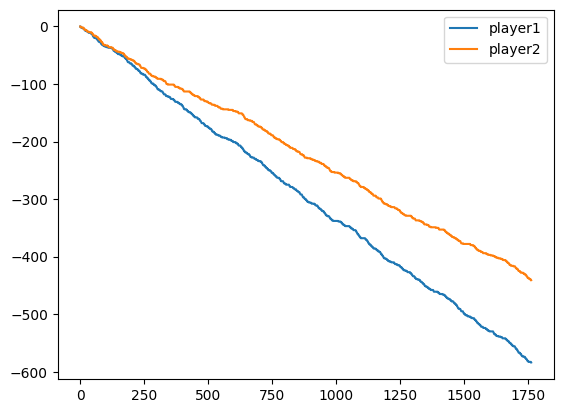

In [22]:
#@title Eval DRL

result = test_collector.collect(n_step=5000)
arr = result["rews"]
death_rates = np.sum(arr, axis=0) / np.sum(arr, axis=0)[0]
print(f"death rate of player2: {(np.sum(arr, axis=0) / arr.shape[0])[-1] * -1:.3f}")
print(f"ratio of death rate of player2 with respect to player1: {death_rates[-1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

In [23]:
#@title Load best model checkpoints

model_save_path1 = os.path.join("log", "hommul", "dqn", "policy1.pth")
model_save_path2 = os.path.join("log", "hommul", "dqn", "policy2.pth")
if not hasattr(policy.policies[agents[0]], 'nolearn'):
    policy.policies[agents[0]].load_state_dict(torch.load(model_save_path1))
if not hasattr(policy.policies[agents[1]], 'nolearn'):
    policy.policies[agents[1]].load_state_dict(torch.load(model_save_path2))

death rate of player2: 0.225
ratio of death rate of player2 with respect to player1: 0.575


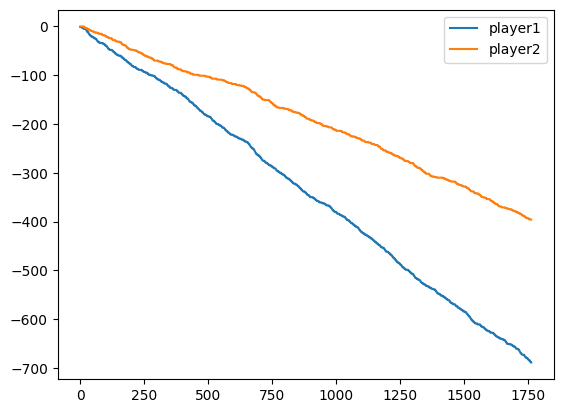

In [24]:
#@title Eval DRL
result = test_collector.collect(n_step=5000)
arr = result["rews"]
death_rates = np.sum(arr, axis=0) / np.sum(arr, axis=0)[0]
print(f"death rate of player2: {(np.sum(arr, axis=0) / arr.shape[0])[-1] * -1:.3f}")
print(f"ratio of death rate of player2 with respect to player1: {death_rates[-1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

In [25]:
#@title Save Policy as CSV

df = []
obs = []

for days_left in range(1, 3):
    for player1_life_points in range(4):
        for player2_life_points in range(4):
            for payoff in [0.2, 0.4]:
                for player1_action in range(0, 3):
                    for player2_action in range(0, 3):
                        curr_obs = [
                            days_left, 
                            player1_life_points, 
                            player2_life_points, 
                            payoff,
                            payoff,
                            player1_action, 
                            player2_action
                        ]
                        obs.append({
                            'agent_id': 'player2',
                            'obs': np.array([curr_obs], dtype='float32'),
                            'mask': [True, True, False]
                        })
                        df.append(curr_obs)

cols = [
    "days_left", 
    "player1_life_points", 
    "player2_life_points", 
    "player1_prob_payoff",
    "player2_prob_payoff",
    "player1_previous_action", 
    "player2_previous_action"
]
df = pd.DataFrame(df, columns=cols)

df["player2_predicted_action"] = policy.policies[agents[1]](Batch(obs=obs, info={})).act
df["player2_logit_wait"] = policy.policies[agents[1]](Batch(obs=obs, info={})).logits.detach().cpu().numpy()[:, 0]
df["player2_logit_play"] = policy.policies[agents[1]](Batch(obs=obs, info={})).logits.detach().cpu().numpy()[:, 1]

df["player1_previous_action"] = df["player1_previous_action"].map({0: "wait", 1: "play", 2: "none"})
df["player2_previous_action"] = df["player2_previous_action"].map({0: "wait", 1: "play", 2: "none"})
df["player2_predicted_action"] = df["player2_predicted_action"].map({0: "wait", 1: "play"})

df.to_csv("outcome_table.csv", index=False)

df.head()

,days_left,player1_life_points,player2_life_points,player1_prob_payoff,player2_prob_payoff,player1_previous_action,player2_previous_action,player2_predicted_action,player2_logit_wait,player2_logit_play
0,1,0,0,0.2,0.2,wait,wait,play,-2.659876,-2.212778
1,1,0,0,0.2,0.2,wait,play,play,-2.783238,-2.571137
2,1,0,0,0.2,0.2,wait,none,wait,-3.074692,-3.131446
3,1,0,0,0.2,0.2,play,wait,play,-2.660012,-1.979891
4,1,0,0,0.2,0.2,play,play,play,-2.681406,-2.113536


In [26]:
#@title Visualize policy (mean gameplay)
(df["player2_predicted_action"] == "play").mean()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.4635416666666667

In [27]:
#@title Visualize policy
df[df["player2_predicted_action"] == "play"].tail(15)

,days_left,player1_life_points,player2_life_points,player1_prob_payoff,player2_prob_payoff,player1_previous_action,player2_previous_action,player2_predicted_action,player2_logit_wait,player2_logit_play
527,2,3,1,0.2,0.2,play,none,play,-2.623579,-2.506845
528,2,3,1,0.2,0.2,none,wait,play,-2.800943,-2.373681
529,2,3,1,0.2,0.2,none,play,play,-2.477022,-2.008962
530,2,3,1,0.2,0.2,none,none,play,-2.274092,-1.889014
531,2,3,1,0.4,0.4,wait,wait,play,-3.249925,-3.043656
532,2,3,1,0.4,0.4,wait,play,play,-3.088605,-3.062900
534,2,3,1,0.4,0.4,play,wait,play,-2.945251,-2.536741
535,2,3,1,0.4,0.4,play,play,play,-2.678582,-2.358937
536,2,3,1,0.4,0.4,play,none,play,-2.643734,-2.476829
537,2,3,1,0.4,0.4,none,wait,play,-2.828171,-2.352279


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


death rate of player2: 0.201
ratio of death rate of player2 with respect to player1: 0.495


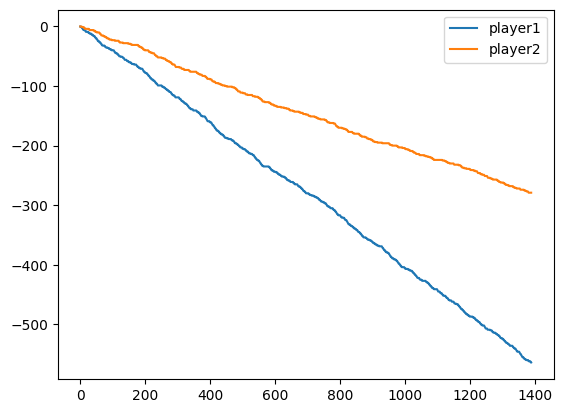

In [28]:
#@title Case - Optimal vs DRL
policy = MultiAgentPolicyManager([OptimalPolicy(), agent_learn2],  _get_env())
test_envs = DummyVectorEnv([_get_env for _ in range(2)])
test_collector = Collector(policy, test_envs, exploration_noise=True)

result = test_collector.collect(n_step=4*1000)
arr = result["rews"]
death_rates = np.sum(arr, axis=0) / np.sum(arr, axis=0)[0]
print(f"death rate of player2: {(np.sum(arr, axis=0) / arr.shape[0])[-1] * -1:.3f}")
print(f"ratio of death rate of player2 with respect to player1: {death_rates[-1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


death rate of player2: 0.179
ratio of death rate of player2 with respect to player1: 0.587


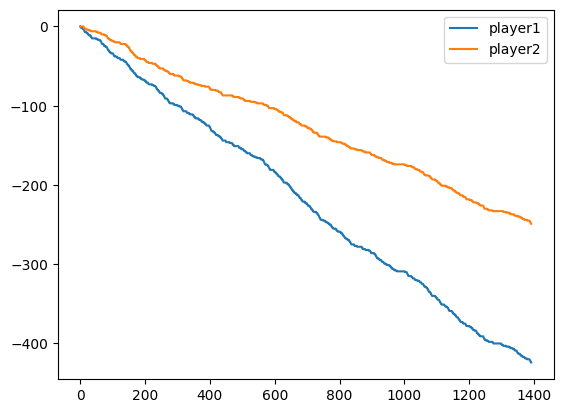

In [29]:
#@title Case - optimal vs optimal
policy = MultiAgentPolicyManager([OptimalPolicy(), OptimalPolicy()],  _get_env())
test_envs = DummyVectorEnv([_get_env for _ in range(2)])
test_collector = Collector(policy, test_envs, exploration_noise=True)

result = test_collector.collect(n_step=4*1000)
arr = result["rews"]
death_rates = np.sum(arr, axis=0) / np.sum(arr, axis=0)[0]
print(f"death rate of player2: {(np.sum(arr, axis=0) / arr.shape[0])[-1] * -1:.3f}")
print(f"ratio of death rate of player2 with respect to player1: {death_rates[-1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

death rate of player2: 0.377
ratio of death rate of player2 with respect to player1: 0.959


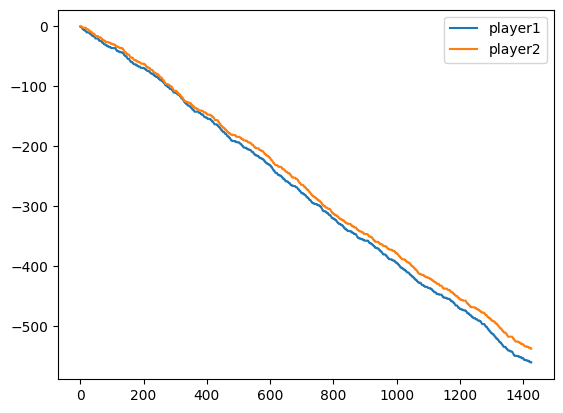

In [30]:
#@title Case - optimal vs Hail Mary
policy = MultiAgentPolicyManager([OptimalPolicy(), HailMary()],  _get_env())
test_envs = DummyVectorEnv([_get_env for _ in range(2)])
test_collector = Collector(policy, test_envs, exploration_noise=True)

result = test_collector.collect(n_step=4*1000)
arr = result["rews"]
death_rates = np.sum(arr, axis=0) / np.sum(arr, axis=0)[0]
print(f"death rate of player2: {(np.sum(arr, axis=0) / arr.shape[0])[-1] * -1:.3f}")
print(f"ratio of death rate of player2 with respect to player1: {death_rates[-1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


death rate of player2: 0.396
ratio of death rate of player2 with respect to player1: 0.938


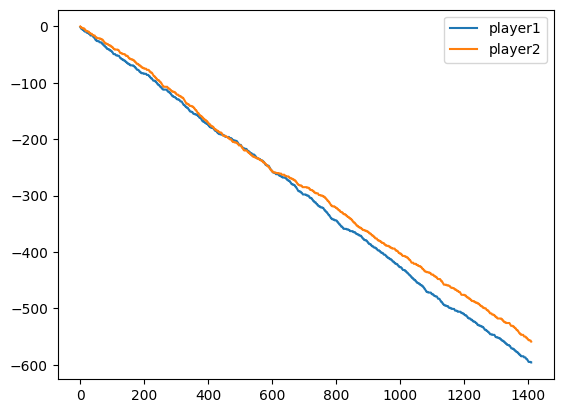

In [31]:
#@title Case - optimal vs random agent
policy = MultiAgentPolicyManager([OptimalPolicy(), RandomAgent()],  _get_env())
test_envs = DummyVectorEnv([_get_env for _ in range(2)])
test_collector = Collector(policy, test_envs, exploration_noise=True)

result = test_collector.collect(n_step=4*1000)
arr = result["rews"]
death_rates = np.sum(arr, axis=0) / np.sum(arr, axis=0)[0]
print(f"death rate of player2: {(np.sum(arr, axis=0) / arr.shape[0])[-1] * -1:.3f}")
print(f"ratio of death rate of player2 with respect to player1: {death_rates[-1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()